In [1]:
import glob
fs=glob.glob('HURR/*h5')
print(fs)
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


['HURR/2AGMI.20221019.049102.07A.19E.ROSLYN.h5', 'HURR/2ADPR.20221019.049102.07A.19E.ROSLYN.h5']


In [2]:
fh=nc.Dataset(fs[1])
def readOrb(orb,n1,n2):
    fh=nc.Dataset(orb)
    sfcPrecip=fh['FS/SLV/precipRateNearSurface'][n1:n2,:]
    precipRate=fh['FS/SLV/precipRate'][n1:n2,:]
    lon=fh['FS/Longitude'][n1:n2,:]
    lat=fh['FS/Latitude'][n1:n2,:]
    hzero=fh['FS/VER/heightZeroDeg'][n1:n2,:]
    pType=fh['FS/CSF/typePrecip'][n1:n2,:]
    stormTop=fh['FS/PRE/heightStormTop'][n1:n2,:]
    #sType=fh['FS/PRE/surfaceType'][n1:n2,:]
    pType=(pType/1e7).astype(np.int32)
    bzd=fh['FS/VER/binZeroDeg'][n1:n2,:]
    zku=fh['FS/PRE/zFactorMeasured'][n1:n2,:,:,:]
    bcf=fh['FS/PRE/binClutterFreeBottom'][n1:n2,:]
    return sfcPrecip,hzero,pType,stormTop,bzd,zku,bcf,precipRate,lon,lat,fh

sfcPrecip,hzero,pType,stormTop,bzd,zku,bcf,precipRate,lon,lat,fh=readOrb(fs[1],100,-100)
print(sfcPrecip.shape)
#Tc=fh['S1/Tc'][:]
#plt.pcolormesh(lon,lat,Tc[:,:,0],cmap='jet')

(137, 49)


Estimating unstructured variogram
-1.093014934369794 2.6665772268502494


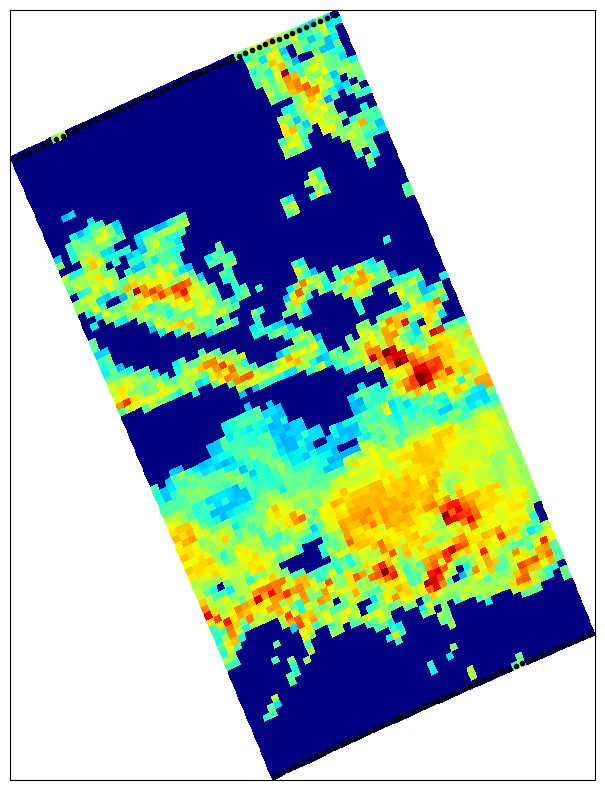

In [35]:
import matplotlib.colors as colors
fig=plt.figure(figsize=(10,10))
ax=plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
sfcPrecip[sfcPrecip<0.01]=0.01
plt.pcolormesh(lon[-98:,:],lat[-98:,:],sfcPrecip[-98:,:],cmap='jet',norm=colors.LogNorm(vmin=0.01,vmax=100))
plt.plot(lon[-98,:],lat[-98,:],'k.')
plt.plot(lon[-1,:],lat[-1,:],'k.')

from gstools import vario_estimate_unstructured

bins = np.linspace(0, 20, 50)
x_u, y_u =np.meshgrid(range(49),range(49))
print('Estimating unstructured variogram')
print(np.log(sfcPrecip[-49:,:]).mean(),np.log(sfcPrecip[-49:,:]).std())
bin_center, gamma = vario_estimate_unstructured(
    (x_u, y_u),
    ((np.log(sfcPrecip[-49:,:])).flatten()+1.0)/2.7,
    bins,
    sampling_size=2000,
    sampling_seed=19920516,
    )


Exponential(dim=2, var=1.08, len_scale=6.3, nugget=0.0)


/Users/mgrecu/miniconda3/lib/python3.9/site-packages/gstools/covmodel/plot.py:114: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


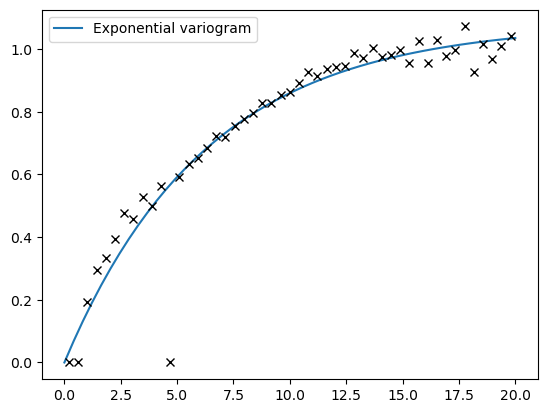

In [22]:
from gstools import Exponential

# fit an exponential model
fit_model = Exponential(dim=2)
fit_model.fit_variogram(bin_center, gamma, nugget=False)

#Finally, we can visualise some results. For quickly plotting a covariance model, GSTools provides some helper functions.

from gstools.covmodel.plot import plot_variogram
#plt.plot(bin_center, gamma)
plot_variogram(fit_model, x_max=bins[-1])
#print(gamma)
plt.plot(bin_center, gamma, "kx", label="unstructured")
print(fit_model)


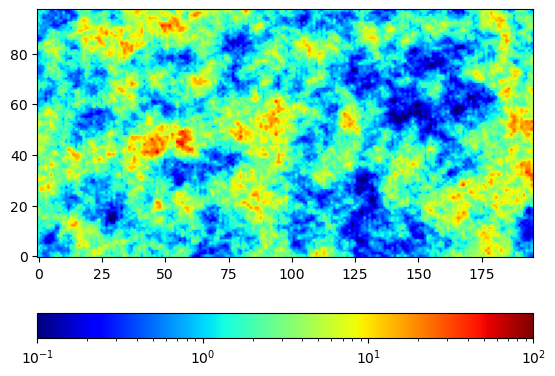

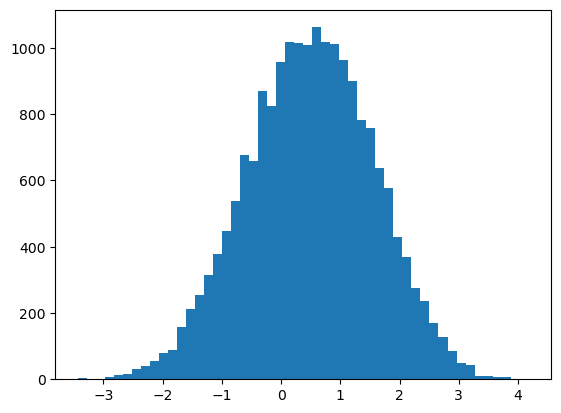

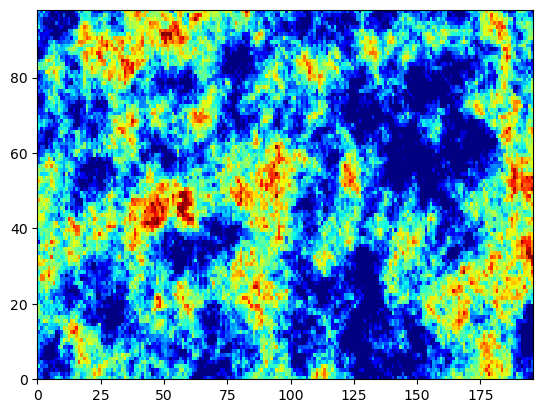

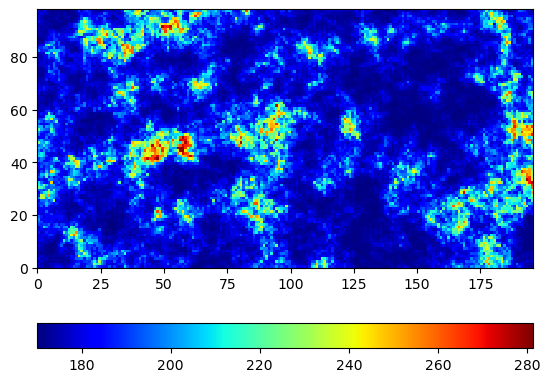

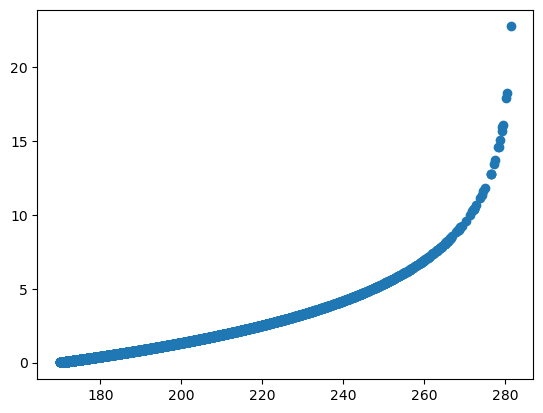

In [77]:
from gstools import SRF



plt.imshow(genField.T, origin='lower',cmap='jet',norm=colors.LogNorm(vmin=0.1,vmax=100))
plt.colorbar(orientation='horizontal')
#plt.show()
plt.figure()
plt.hist(np.log(genField.flatten()),bins=50)
attKuCoeff=(1.08783315, -3.61981317)
attKu=np.exp(attKuCoeff[0]*np.log(genField)+attKuCoeff[1])*9

plt.figure()
plt.pcolormesh(attKu.T,cmap='jet',norm=colors.LogNorm(vmin=0.1,vmax=10))

tb=282-np.exp((attKu-20.043)/(-4.247))
plt.figure()
plt.pcolormesh(tb.T,cmap='jet')#,vmin=160,vmax=280)
plt.colorbar(orientation='horizontal')
plt.figure()
plt.scatter(tb.flatten(),attKu.flatten())


In [70]:
from scipy.signal import convolve2d 

gainField=np.zeros((7,5))
for i in range(7):
    for j in range(5):
        gainField[i,j]=np.exp(-4*np.log(2)*(((i-3)*4.5)**2/32**2+((j-2)*4.5)**2/19**2))

gainField=gainField/gainField.sum()

tb2dConv=convolve2d(tb, gainField, mode='valid')


(190, 94)
(196, 98)


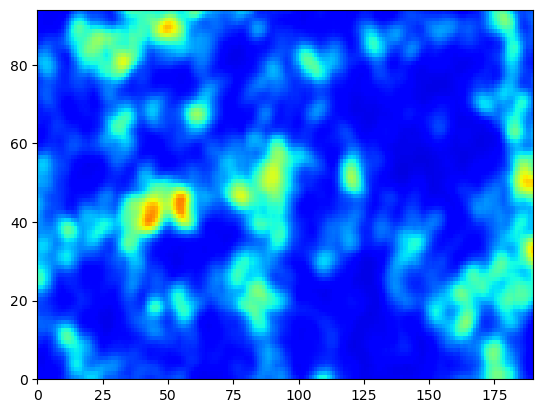

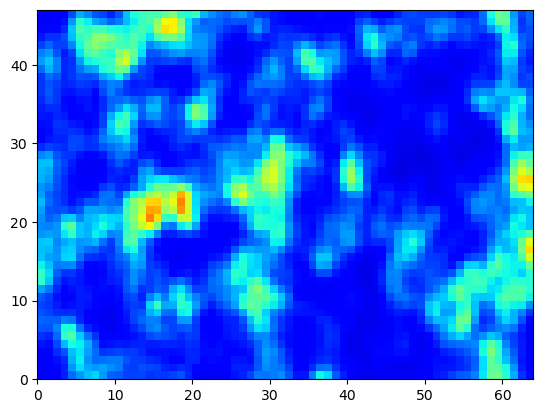

In [76]:
print(tb2dConv.shape)
plt.figure()
plt.pcolormesh(tb2dConv.T,cmap='jet',vmin=160,vmax=280)
plt.figure()
plt.pcolormesh(tb2dConv[::3,::2].T,cmap='jet',vmin=160,vmax=280)
print(tb.shape)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'asymBB', 'asymG', 'asymH', 'asymR', 'asymS', 'attKaBB', 'attKaG', 'attKaH', 'attKaR', 'attKaS', 'attKuBB', 'attKuG', 'attKuH', 'attKuR', 'attKuS', 'dmBB', 'dmg', 'dmh', 'dmr', 'dms', 'fh', 'fhBB', 'graupRate', 'gwc', 'hailRate', 'hwc', 'kextBB', 'kextG', 'kextH', 'kextR', 'kextS', 'precRateBB', 'rainRate', 'rwc', 'salbBB', 'salbG', 'salbH', 'salbR', 'salbS', 'snowRate', 'swc', 'zKaBB', 'zKaG', 'zKaR', 'zKaS', 'zKah', 'zKuBB', 'zKuG', 'zKuR', 'zKuS', 'zKuh']
[ 1.08783315 -3.61981317]


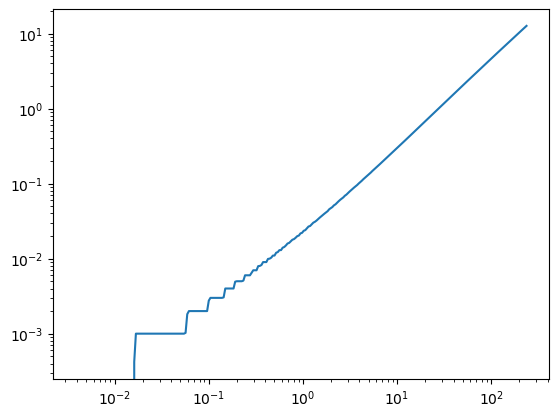

In [62]:
import sys
sys.path.append('/Users/mgrecu/myPythonPackages/')
import lkTables as lkT
from bisectm import bisectm
lkTables=lkT.scattTables()
$print(dir(lkTables))
plt.loglog(lkTables.rainRate,lkTables.attKuR)
import numpy as np
attKuCoeff=np.polyfit(np.log(lkTables.rainRate[50:]),np.log(lkTables.attKuR[50:]),1)
print(attKuCoeff)

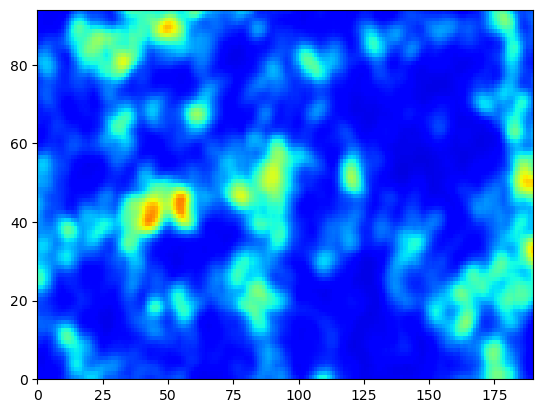

In [79]:
import pickle
with open('fit_model.pkl','wb') as f:
    pickle.dump({"fit_model":fit_model},f)

with open('fit_model.pkl','rb') as f:
    fit_model=pickle.load(f)["fit_model"]

seed_value=19770938
attKuCoeff=(1.08783315, -3.61981317)
from scipy.signal import convolve2d 

gainField=np.zeros((7,5))
for i in range(7):
    for j in range(5):
        gainField[i,j]=np.exp(-4*np.log(2)*(((i-3)*4.5)**2/32**2+((j-2)*4.5)**2/19**2))

gainField=gainField/gainField.sum()
tb2dConv=convolve2d(tb, gainField, mode='valid')
def simTb(seed_value,attKuCoeff):
    srf = SRF(fit_model, seed=seed_value)
    x_s, y_s = range(2*98),range(2*49)
    new_herten = srf((x_s, y_s), mesh_type='structured')
    genField=np.exp(new_herten-1.25)*6.5
    attKu=np.exp(attKuCoeff[0]*np.log(genField)+attKuCoeff[1])*9
    tb=282-np.exp((attKu-20.043)/(-4.247))
    tb2dConv=convolve2d(tb, gainField, mode='valid')
    return tb2dConv,tb,genField

tb2dConv_2,tb_2,genField_2=simTb(seed_value,attKuCoeff)

plt.figure()
plt.pcolormesh(tb2dConv_2.T,cmap='jet',vmin=160,vmax=280)